In [1]:
from __future__ import annotations

import tempfile

from pydiverse.pipedag import Flow, Stage, materialize, GroupNode, VisualizationStyle
from pydiverse.pipedag.core.config import create_basic_pipedag_config
from pydiverse.pipedag.util.structlog import setup_logging


@materialize
def any_task():
    return 1

@materialize
def task_within_group():
    return 2

@materialize
def task_within_group2(input1: int):
    return input1 + 1


In [2]:
setup_logging()
temp_dir = tempfile.TemporaryDirectory()
temp_dir_str = temp_dir.__enter__()

In [3]:
cfg = create_basic_pipedag_config(
    f"duckdb:///{temp_dir_str}/db.duckdb",
    disable_stage_locking=True,  # This is special for duckdb
    # Attention: stage and task names might be sent to the
    #   following URL. You can self-host kroki if you like:
    #   https://docs.kroki.io/kroki/setup/install/
    kroki_url="https://kroki.io",
).get("default")

2024-04-16 12:45:25.664422 [info     ] Initialized SQL Table Store    [DuckDBTableStore] engine_url=duckdb:////tmp/tmp96kguquv/db.duckdb schema_prefix= schema_suffix=


In [4]:
with Flow() as flow:
    with Stage("stage1"):
        _ = any_task()
        with GroupNode(
                "group1", ordering_barrier=True, 
                style=VisualizationStyle(hide_content=True, box_color_always="#ccccff")
        ):
            task1 = task_within_group()
            _ = task_within_group2(task1)
        _ = any_task()

In [5]:
# Run flow
result = flow.run(config=cfg)
assert result.successful

2024-04-16 12:45:25.710323 [info     ] Initialized SQL Table Store    [DuckDBTableStore] engine_url=duckdb:////tmp/tmp96kguquv/db.duckdb schema_prefix= schema_suffix=
2024-04-16 12:45:25.711479 [info     ] Starting IPCServer             [RunContextServer] address=tcp://127.0.0.1:37675
2024-04-16 12:45:25.733683 [info     ] Executing sql                  [DuckDBTableStore]
    [query]
    CREATE SCHEMA IF NOT EXISTS pipedag_metadata
2024-04-16 12:45:25.844742 [info     ] Executing sql                  [DuckDBTableStore]
    [query]
    CREATE SCHEMA IF NOT EXISTS stage1
2024-04-16 12:45:25.846739 [info     ] Executing sql                  [DuckDBTableStore]
    [query]
    DROP SCHEMA IF EXISTS stage1__odd CASCADE
2024-04-16 12:45:25.847577 [info     ] Executing sql                  [DuckDBTableStore]
    [query]
    CREATE SCHEMA stage1__odd
2024-04-16 12:45:25.862978 [info     ] Task finished successfully     [Task 'any_task'] state=<FinalTaskState.COMPLETED: 1> task=<Task 'any_task' 

2024-04-16 12:45:26.139611 [info     ] No visualization customization found in config. [Flow]


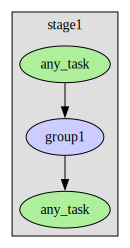

In [6]:
result.visualize()

In [7]:
from pydiverse.pipedag.core.config import PipedagConfig
base_cfg = create_basic_pipedag_config(
    f"duckdb:///{temp_dir_str}/db.duckdb",
    disable_stage_locking=True,  # This is special for duckdb
    # Attention: If uncommented, stage and task names might be sent to the
    #   following URL. You can self-host kroki if you like:
    #   https://docs.kroki.io/kroki/setup/install/
    kroki_url="https://kroki.io",
)
group_nodes = dict(
    my_group1=dict(tasks=["task_within_group", "task_within_group2"], label="Group 1", style_tag="my_group_style"),
)
styles = dict(
    my_group_style=dict(hide_content=True, box_color_always="#ccccff"),
)
visualization = dict(default=dict(group_nodes=group_nodes, styles=styles), alternative={})
raw_cfg = base_cfg.raw_config.copy()
raw_cfg["instances"]["__any__"]["visualization"] = visualization
cfg = PipedagConfig(raw_cfg).get()

2024-04-16 12:45:26.178033 [info     ] Initialized SQL Table Store    [DuckDBTableStore] engine_url=duckdb:////tmp/tmp96kguquv/db.duckdb schema_prefix= schema_suffix=


In [8]:
with Flow() as flow:
    with Stage("stage1"):
        task1 = task_within_group()
        _ = task_within_group2(task1)
        _ = any_task()

2024-04-16 12:45:26.193385 [info     ] Initialized SQL Table Store    [DuckDBTableStore] engine_url=duckdb:////tmp/tmp96kguquv/db.duckdb schema_prefix= schema_suffix=
2024-04-16 12:45:26.194232 [info     ] Starting IPCServer             [RunContextServer] address=tcp://127.0.0.1:43623
2024-04-16 12:45:26.202765 [info     ] Executing sql                  [DuckDBTableStore]
    [query]
    CREATE SCHEMA IF NOT EXISTS pipedag_metadata
2024-04-16 12:45:26.211927 [info     ] Executing sql                  [DuckDBTableStore]
    [query]
    CREATE SCHEMA IF NOT EXISTS stage1
2024-04-16 12:45:26.213131 [info     ] Executing sql                  [DuckDBTableStore]
    [query]
    DROP SCHEMA IF EXISTS stage1__odd CASCADE
2024-04-16 12:45:26.215403 [info     ] Executing sql                  [DuckDBTableStore]
    [query]
    CREATE SCHEMA stage1__odd
2024-04-16 12:45:26.234152 [info     ] Task finished successfully     [Task 'task_within_group'] state=<FinalTaskState.COMPLETED: 1> task=<Task 't

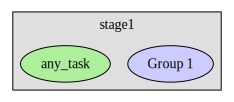

In [9]:
# Run flow
result = flow.run(config=cfg)
assert result.successful
result.visualize()

In [10]:
temp_dir.__exit__(None, None, None)